In [1]:
import sys
sys.path.append('..')

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml

from dataloader_cocostyle import CrowdAI, image_graph_collate_road_network_coco, min_max_normalize
from dataset_inria import build_inria_data
from pretrain import dict2obj

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Built Dataset Options:
--Num.of images: 1595
--Gap Distance: 10 --Sigma: 0.8 --nms: False
torch.Size([6, 3, 320, 320])
0.97407705 0.0


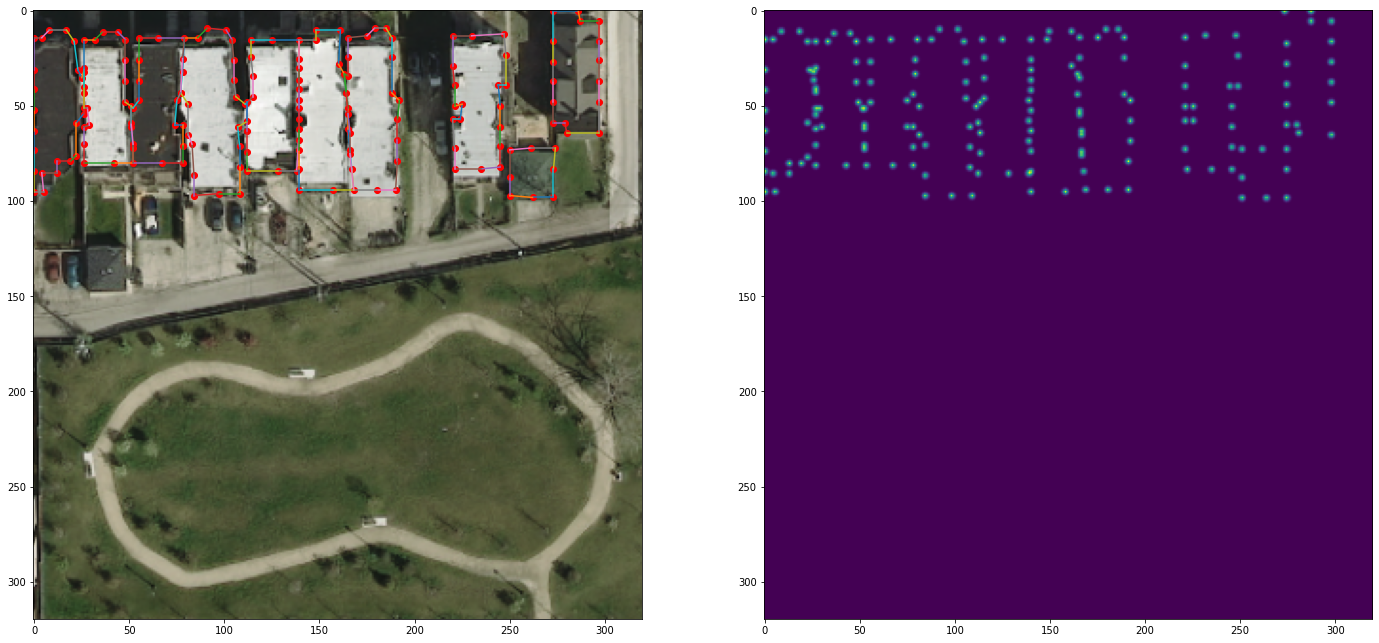

In [5]:
dataset = CrowdAI(images_directory='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_framefield_test/images',
                    annotations_path='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_framefield_test/annotation.json',
                    gap_distance=10,
                    sigma=0.8,
                    nms=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, collate_fn=image_graph_collate_road_network_coco, shuffle=False)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

image = data[0][1].detach().cpu().numpy().transpose(1,2,0)
heatmap = data[1][1].detach().cpu().numpy()[0]
nodes = data[2][1].detach().cpu().numpy() * image.shape[0]
edges = data[3][1].detach().cpu().numpy()

nodes = nodes.astype('int64')

print(heatmap.max(), heatmap.min())

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(24,12))
ax[0].imshow(min_max_normalize(image, 0))
ax[0].scatter(nodes[:,1], nodes[:,0], color='r')

for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    ax[0].plot(connect[:,1], connect[:,0])

ax[1].imshow(heatmap)
plt.show()


*** Config file
../configs/inria_pretrain.yaml
Baseline TopDig-Node-Detector for road network
torch.Size([6, 3, 320, 320])
0.9882353 0.0


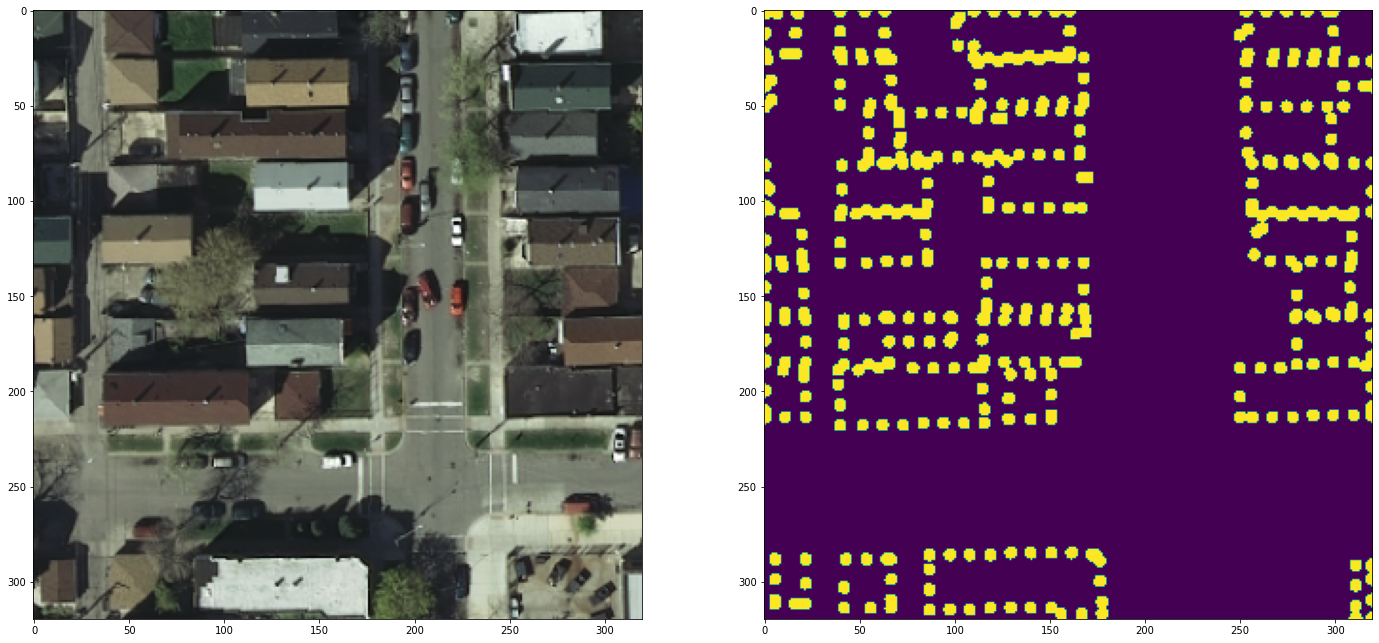

In [26]:
config_file = '../configs/inria_pretrain.yaml'
with open(config_file) as f:
    print('\n*** Config file')
    print(config_file)
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(config['log']['message'])
config = dict2obj(config)
dataset = build_inria_data(config)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=False)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

# image_data, ann_data, htm_data
image = data[0][3].detach().cpu().numpy().transpose(1,2,0)
ann = data[1][3].detach().cpu().numpy()[0]
heatmap = data[2][3].detach().cpu().numpy()[0]
print(heatmap.max(), heatmap.min())

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(24,12))
ax[0].imshow(min_max_normalize(image, 0))

ax[1].imshow(heatmap > 0.0)
plt.show()